In [1]:
import cripser
import numpy as np
import matplotlib.pyplot as plt
import pandas

# generate image 

def generate_2d_gaussian(A,shape, center, sigma_x, sigma_y, angle_deg=0):
    """
    Generate a 2D elliptical Gaussian distribution on a 2D array.

    Parameters:
        shape (tuple): Shape of the output array (height, width).
        center (tuple): Center of the Gaussian distribution (x, y).
        sigma_x (float): Standard deviation along the x-axis.
        sigma_y (float): Standard deviation along the y-axis.
        angle_deg (float): Rotation angle in degrees (default is 0).

    Returns:
        ndarray: 2D array containing the Gaussian distribution.
    """
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    x_c, y_c = center
    angle_rad = np.radians(angle_deg)
    
    # Rotate coordinates
    x_rot = (x - x_c) * np.cos(angle_rad) - (y - y_c) * np.sin(angle_rad)
    y_rot = (x - x_c) * np.sin(angle_rad) + (y - y_c) * np.cos(angle_rad)
    
    # Calculate Gaussian values
    gaussian = A*np.exp(-(x_rot ** 2 / (2 * sigma_x ** 2) + y_rot ** 2 / (2 * sigma_y ** 2)))
    
    return gaussian / (2 * np.pi * sigma_x * sigma_y) # normalize the gaussian


def get_enclosing_mask(x, y, mask):
    '''
    Returns the mask of the enclosed area of the point (x,y) in the mask.
    '''
    
    # Ensure the point is inside the mask
    if not mask[y, x]:
        return None
    # Create a copy of the mask
    enclosed_mask = np.copy(mask)
    # Perform a flood fill starting from the point
    h, w = mask.shape
    stack = [(x, y)]
    while stack:
        x, y = stack.pop()
        if enclosed_mask[y, x]:
            enclosed_mask[y, x] = False
            if x > 0:
                stack.append((x - 1, y))
            if x < w - 1:
                stack.append((x + 1, y))
            if y > 0:
                stack.append((x, y - 1))
            if y < h - 1:
                stack.append((x, y + 1))
    
    return mask & (~enclosed_mask)



In [2]:
size = 500
gauss1 = generate_2d_gaussian(1,(size,size),(140,140),2,2,0) # bright spot
gauss2 = generate_2d_gaussian(9,(size,size),(150,150),10,2,-45) # jet
gauss3 = generate_2d_gaussian(9,(size,size),(120,120),10,2,-45) # jet
gauss4 = generate_2d_gaussian(20,(size,size),(100,90),10,20,20) # bright spot
gauss5 = generate_2d_gaussian(20,(size,size),(180,180),10,20,0) # bright spot
noise = 0.01*np.random.normal(0,0.001,(size,size))
img = gauss1 + gauss2 + gauss3 + gauss4 + gauss5  + noise

In [3]:
size = 500
gauss1 = generate_2d_gaussian(1, (size, size), (300, 300), 3, 3,0)
gauss2 = generate_2d_gaussian(1, (size, size), (250, 250), 3, 3,0)
gauss3 = generate_2d_gaussian(10, (size, size), (260, 260), 10, 20,45)
gauss4 = generate_2d_gaussian(2, (size, size), (350, 350), 3, 3,0)
gauss5 = generate_2d_gaussian(10, (size, size), (340, 340), 10, 20,45)
img = img + gauss1 + gauss2 + gauss3 + gauss4 + gauss5


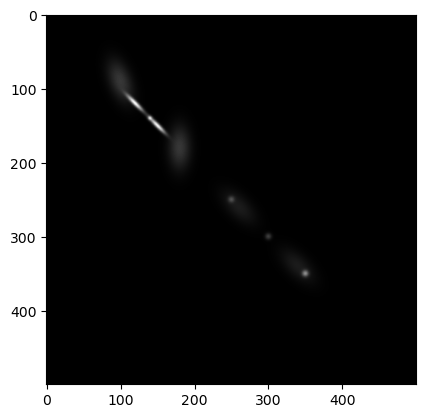

In [4]:
plt.imshow(img, cmap='gray')
plt.show()

In [5]:
from astropy.stats import mad_std

local_bg = mad_std(img)
sigma = 5
pd = cripser.computePH(-img,maxdim=0)
pd = pandas.DataFrame(pd,columns=['dim','Birth','Death','x1','y1','z1','x2','y2','z2'],index=range(1,len(pd)+1))
pd.drop(columns=['dim','z1','z2'],inplace=True)
pd['lifetime'] = pd['Death'] - pd['Birth']
pd['Birth'] = -pd['Birth'] # negative for max filtration
pd['Death'] = -pd['Death'] # negative for max filtration
pd['Death'] = np.where(pd['Death'] < local_bg*sigma, local_bg*sigma, pd['Death'])
pd['lifetime'] = abs(pd['Death'] - pd['Birth'])
pd = pd[pd['Birth']>local_bg*sigma]
pd = pd[pd['lifetime'] > local_bg*sigma]

pd

,Birth,Death,x1,y1,x2,y2,lifetime
1,0.073712,0.069762,119.0,119.0,120.0,119.0,0.003949
2,0.072938,0.069374,121.0,121.0,121.0,120.0,0.003564
3,0.072089,0.068865,118.0,118.0,119.0,118.0,0.003224
4,0.070533,0.067725,122.0,122.0,122.0,121.0,0.002809
5,0.071003,0.067201,151.0,151.0,150.0,151.0,0.003802
6,0.070967,0.067171,149.0,149.0,149.0,150.0,0.003796
7,0.069212,0.066788,117.0,117.0,118.0,117.0,0.002424
8,0.068937,0.065900,152.0,152.0,151.0,152.0,0.003037
9,0.068877,0.065852,148.0,148.0,148.0,149.0,0.003025
10,0.066908,0.064821,123.0,123.0,123.0,122.0,0.002088


In [6]:
# remove points that only live for one pixel

def remove_1pixel_points(row):
    # create mask for each point
    distx = abs(row.x1-row.x2) 
    disty = abs(row.y1-row.y2)
    # if any of the points are 1 pixel away, then return 1
    if distx <= 1 or disty <= 1:
        dist = 1
    else:
        dist = 2
    return dist

pd['dist'] = pd.apply(lambda row: remove_1pixel_points(row),axis=1)
pd = pd[pd['dist']>1]
pd


,Birth,Death,x1,y1,x2,y2,lifetime,dist
28,0.067486,0.046127,140.0,140.0,144.0,143.0,0.021359,2
32,0.071699,0.014442,150.0,150.0,135.0,134.0,0.057257,2
33,0.015924,0.009272,180.0,180.0,168.0,168.0,0.006651,2
36,0.007950,0.007884,340.0,340.0,342.0,343.0,0.000067,2
37,0.007966,0.007854,260.0,260.0,257.0,258.0,0.000112,2
38,0.017963,0.000628,300.0,300.0,292.0,293.0,0.017335,2
39,0.023881,0.000620,250.0,250.0,308.0,307.0,0.023261,2
238,0.041565,0.000069,350.0,350.0,218.0,209.0,0.041496,2
44489,0.074019,0.000061,120.0,120.0,0.0,0.0,0.073958,2


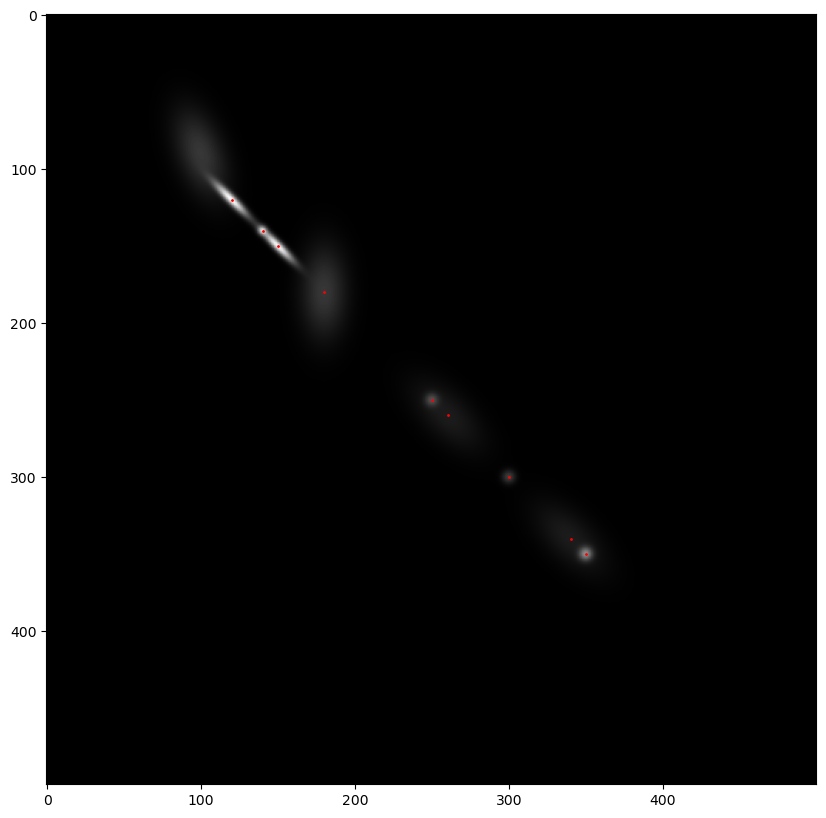

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.scatter(x=pd.x1, y=pd.y1, c='r', s=1)
plt.show()

In [8]:
def make_point_enclosure_assoc(row,img,pd):
    '''
    Returns a list of the indices of the points that are enclosed by the mask pd point.
    '''
    point = row
    mask = np.zeros(img.shape)
    mask = np.logical_or(mask,np.logical_and(img <= point.Birth,img > point.Death))
    #plt.imshow(mask)
    #plt.scatter(point.x1,point.y1)
    #plt.show()
    mask_enclosed = get_enclosing_mask(int(point.y1),int(point.x1),mask)
    
    # check if any brith points from other points are inside the mask
    
    encloses = []
    for i in range(len(pd)):
        point = pd.loc[i]
        if point.name == row.name:
            continue
        if mask_enclosed[int(point.x1),int(point.y1)]:
            # add column to pd    
            encloses.append(point.name)

    return encloses

# find the point that is first destroyed by the highest brith.
pd.sort_values(by='Birth',ascending=False,inplace=True,ignore_index=True)
pd['enclosed_i'] = pd.apply(lambda row: make_point_enclosure_assoc(row,img,pd),axis=1)
pd

/var/folders/8t/sjjwscn938b2778wvp7v4f380000gq/T/ipykernel_47419/2360231998.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd.sort_values(by='Birth',ascending=False,inplace=True,ignore_index=True)
/var/folders/8t/sjjwscn938b2778wvp7v4f380000gq/T/ipykernel_47419/2360231998.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd['enclosed_i'] = pd.apply(lambda row: make_point_enclosure_assoc(row,img,pd),axis=1)


,Birth,Death,x1,y1,x2,y2,lifetime,dist,enclosed_i
0,0.074019,0.000061,120.0,120.0,0.0,0.0,0.073958,2,"[1, 2, 3, 4, 5, 6, 7, 8]"
1,0.071699,0.014442,150.0,150.0,135.0,134.0,0.057257,2,[2]
2,0.067486,0.046127,140.0,140.0,144.0,143.0,0.021359,2,[]
3,0.041565,0.000069,350.0,350.0,218.0,209.0,0.041496,2,"[4, 5, 7, 8]"
4,0.023881,0.000620,250.0,250.0,308.0,307.0,0.023261,2,"[5, 7]"
5,0.017963,0.000628,300.0,300.0,292.0,293.0,0.017335,2,[]
6,0.015924,0.009272,180.0,180.0,168.0,168.0,0.006651,2,[]
7,0.007966,0.007854,260.0,260.0,257.0,258.0,0.000112,2,[]
8,0.007950,0.007884,340.0,340.0,342.0,343.0,0.000067,2,[]


In [9]:
def correct_first_destruction(pd):
    pd['new_row'] = 0
    for i in range(0,len(pd)):
        row = pd.iloc[i]
        enclosed_i = row['enclosed_i']
        # if enlosed_i is empty then skip
        if len(enclosed_i) > 1:
            # create a new row copied from the current row
            new_row = row.copy()
            new_row['Death'] = pd.iloc[enclosed_i[0]]['Death']
            new_row['new_row'] = 1
            # add new row to the dataframe
            pd = pd.append(new_row, ignore_index=True)

    return pd


pd = correct_first_destruction(pd)
pd

/var/folders/8t/sjjwscn938b2778wvp7v4f380000gq/T/ipykernel_47419/3121742326.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd['new_row'] = 0
/var/folders/8t/sjjwscn938b2778wvp7v4f380000gq/T/ipykernel_47419/3121742326.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd = pd.append(new_row, ignore_index=True)


,Birth,Death,x1,y1,x2,y2,lifetime,dist,enclosed_i,new_row
0,0.074019,0.000061,120.0,120.0,0.0,0.0,0.073958,2,"[1, 2, 3, 4, 5, 6, 7, 8]",0
1,0.071699,0.014442,150.0,150.0,135.0,134.0,0.057257,2,[2],0
2,0.067486,0.046127,140.0,140.0,144.0,143.0,0.021359,2,[],0
3,0.041565,0.000069,350.0,350.0,218.0,209.0,0.041496,2,"[4, 5, 7, 8]",0
4,0.023881,0.000620,250.0,250.0,308.0,307.0,0.023261,2,"[5, 7]",0
5,0.017963,0.000628,300.0,300.0,292.0,293.0,0.017335,2,[],0
6,0.015924,0.009272,180.0,180.0,168.0,168.0,0.006651,2,[],0
7,0.007966,0.007854,260.0,260.0,257.0,258.0,0.000112,2,[],0
8,0.007950,0.007884,340.0,340.0,342.0,343.0,0.000067,2,[],0
9,0.074019,0.014442,120.0,120.0,0.0,0.0,0.073958,2,"[1, 2, 3, 4, 5, 6, 7, 8]",1


In [10]:
def parent_tag_func(row):
    # search for yourself in anouther points enclosed_i
    for i in range(len(pd)):
        if row.name in pd.iloc[i].enclosed_i:
            return pd.iloc[i].name
    return np.nan

def classify_point(row):
    if row.new_row == 0:
        if len(row.enclosed_i) == 0:
            if np.isnan(row.parent_tag):
                return 0 # no children, no parent.
            else:
                return 1 # no child has parent.
        else:
            return 2 # has children.
    else:
        return 3 # new row has children.
    
pd['parent_tag'] = pd.apply(parent_tag_func, axis=1)
pd['single'] = pd.apply(classify_point, axis=1)
pd

,Birth,Death,x1,y1,x2,y2,lifetime,dist,enclosed_i,new_row,parent_tag,single
0,0.074019,0.000061,120.0,120.0,0.0,0.0,0.073958,2,"[1, 2, 3, 4, 5, 6, 7, 8]",0,NaN,2
1,0.071699,0.014442,150.0,150.0,135.0,134.0,0.057257,2,[2],0,0.0,2
2,0.067486,0.046127,140.0,140.0,144.0,143.0,0.021359,2,[],0,0.0,1
3,0.041565,0.000069,350.0,350.0,218.0,209.0,0.041496,2,"[4, 5, 7, 8]",0,0.0,2
4,0.023881,0.000620,250.0,250.0,308.0,307.0,0.023261,2,"[5, 7]",0,0.0,2
5,0.017963,0.000628,300.0,300.0,292.0,293.0,0.017335,2,[],0,0.0,1
6,0.015924,0.009272,180.0,180.0,168.0,168.0,0.006651,2,[],0,0.0,1
7,0.007966,0.007854,260.0,260.0,257.0,258.0,0.000112,2,[],0,0.0,1
8,0.007950,0.007884,340.0,340.0,342.0,343.0,0.000067,2,[],0,0.0,1
9,0.074019,0.014442,120.0,120.0,0.0,0.0,0.073958,2,"[1, 2, 3, 4, 5, 6, 7, 8]",1,NaN,3


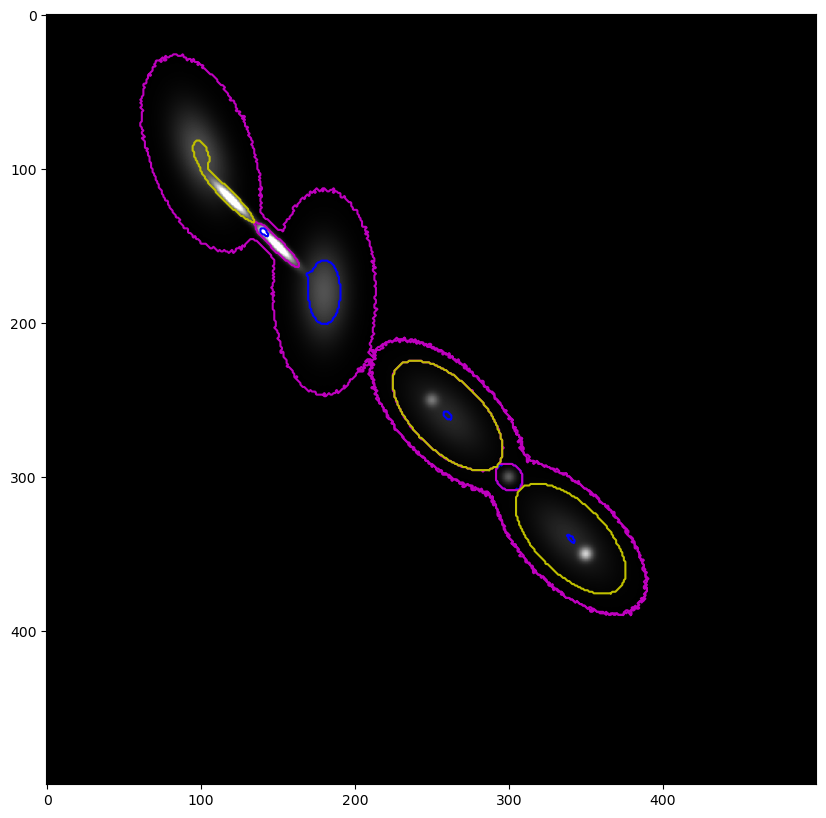

In [11]:
# create contours for each birth and death
# plot the contours
from skimage import measure

cat0 = pd[pd['single']==0]
cat1 = pd[pd['single']==1]
cat2 = pd[pd['single']==2]
cat3 = pd[pd['single']==3]

plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray',vmax=0.05)

for i in range(len(cat0)):
    row = cat0.iloc[i]
    birth = row['Birth']
    death = row['Death']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.x1),int(row.y1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='r')

for i in range(len(cat1)):
    try:
        row = cat1.iloc[i]
        birth = row['Birth']
        death = row['Death']
        mask = np.logical_and(img<=birth, img>death)
        mask = get_enclosing_mask(int(row.x1),int(row.y1),mask)
        contour = measure.find_contours(mask)[0]
        plt.plot(contour[:,1],contour[:,0],color='b')
    except:
        print(row.name)
        print(mask)
        continue    

for i in range(len(cat2)):
    try:
        row = cat2.iloc[i]
        death = row['Death']
        birth = row['Birth']
        mask = np.logical_and(img<=birth, img>death)
        mask = get_enclosing_mask(int(row.x1),int(row.y1),mask)
        contour = measure.find_contours(mask)[0]
        plt.plot(contour[:,1],contour[:,0],color='m')
    except:
        print(i)
        continue

for i in range(len(cat3)):
    row = cat3.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='y')
'''
contours = []
for i in range(len(pd)):
    row = pd.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.x1),int(row.y1),mask)
    contour = measure.find_contours(mask)[0]
    contours.append(contour)
    plt.figure(figsize=(10,10))
    plt.imshow(img,cmap='gray',vmax=0.01)
    plt.plot(contour[:,1],contour[:,0],color='y')
'''
plt.show()

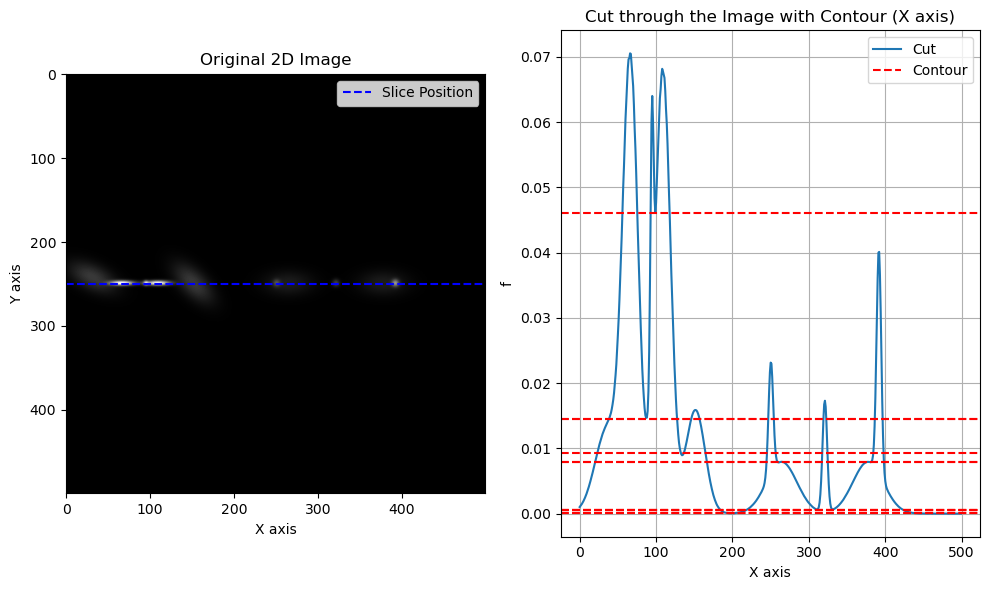

In [12]:

from skimage.transform import rotate
def plot_cut_with_contour(image, cut_axis, cut_position,contour_level,rotation_angle=0):
    """
    Plot a cut through the image with a contour line and show the slice on the 2D image.

    Parameters:
    image (numpy.ndarray): The 2D input image.
    cut_axis (str): 'x' or 'y', indicating the axis along which the cut should be made.
    cut_position (int): The index of the position along the cut_axis where the cut is made.
    rotation_angle (float): Angle in degrees to rotate the image (optional, default is 0).
    """
    # Rotate the image if requested
    image = rotate(image, rotation_angle, preserve_range=True, mode='reflect')

    if cut_axis == 'x':
        cut = image[cut_position, :]
        slice_line = image[cut_position, :]
    elif cut_axis == 'y':
        cut = image[:, cut_position]
        slice_line = image[:, cut_position]
    else:
        raise ValueError("cut_axis must be 'x' or 'y'.")

    # Rotate the image if requested
    rotated_image = rotate(image, rotation_angle, preserve_range=True, mode='reflect')

    # Find the contours in the rotated image
    # Create the plot
    plt.figure(figsize=(10, 6))

    # Plot the 2D image
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.axhline(cut_position, color='blue', linestyle='dashed', label='Slice Position')
    plt.title('Original 2D Image')
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.legend()

    # Plot the cut through the image with contour
    plt.subplot(1, 2, 2)
    plt.plot(slice_line, label='Cut')
    LABEL = False
    for i in range(len(contour_level)):
        if LABEL == False:
            plt.axhline(contour_level.iloc[i], color='red', linestyle='dashed',label='Contour')
            LABEL = True
        else:

            plt.axhline(contour_level.iloc[i], color='red', linestyle='dashed')
    plt.title(f'Cut through the Image with Contour ({cut_axis.upper()} axis)')
    plt.xlabel(f'{cut_axis.upper()} axis')
    plt.ylabel('f')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

cut_axis = 'x'
cut_position = 250
rotation_angle = 45
plot_cut_with_contour(img, cut_axis, cut_position,pd.Death,rotation_angle)

In [13]:
from astropy.io import fits
# open fits file and run on image
FITS_DIR = '/Users/rs17612/Documents/Radio_Data/MIGHTEE/MIGHTEE_Continuum_Early_Science_COSMOS_r0p0.app.restored.circ.fits'

# open fits file and run on image
hdu = fits.open(FITS_DIR)[0]
img = hdu.data[0,0,2000:3000,2000:3000]
header = hdu.header

local_bg = mad_std(img)
sigma = 5

pd = cripser.computePH(-img,maxdim=0)
pd = pandas.DataFrame(pd,columns=['dim','Birth','Death','x1','y1','z1','x2','y2','z2'],index=range(1,len(pd)+1))
pd.drop(columns=['dim','z1','z2'],inplace=True)
pd['lifetime'] = pd['Death'] - pd['Birth']
pd['Birth'] = -pd['Birth'] # negative for max filtration
pd['Death'] = -pd['Death'] # negative for max filtration
pd['Death'] = np.where(pd['Death'] < local_bg*sigma, local_bg*sigma, pd['Death'])
pd['lifetime'] = abs(pd['Death'] - pd['Birth'])
pd = pd[pd['Birth']>local_bg*sigma]
#pd = pd[pd['lifetime'] > local_bg*sigma]

pd['dist'] = pd.apply(lambda row: remove_1pixel_points(row),axis=1)
print(pd)
#pd = pd[pd['dist'] > 1]

pd.sort_values(by='Birth',ascending=False,inplace=True,ignore_index=True)
pd['enclosed_i'] = pd.apply(lambda row: make_point_enclosure_assoc(row,img,pd),axis=1)
pd = correct_first_destruction(pd)
pd['parent_tag'] = pd.apply(parent_tag_func, axis=1)
pd['single'] = pd.apply(classify_point, axis=1)

cat0 = pd[pd['single']==0]
#print(len(cat0))
cat1 = pd[pd['single']==1]
#print(len(cat1))
cat2 = pd[pd['single']==2]
#print(len(cat2))
cat3 = pd[pd['single']==3]
#print(len(cat3))
#print(cat0)
'''
plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray',origin='lower',vmax=0.0001)

for i in range(len(cat0)):
    row = cat0.iloc[i]
   # print(row)
    birth = row['Birth']
    death = row['Death']
    mask = np.zeros(img.shape)
    mask = np.logical_or(mask,np.logical_and(img<=birth, img>death))
    #print(birth,death)
    #print(img[int(row.x1),int(row.y1)])
    #plt.scatter(row.y1,row.x1,color='r',marker='+')
    #plt.imshow(img,cmap='gray',origin='lower',vmax=0.001)
    #plt.show()
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='r')
    
    #    continue
    #except:

for i in range(len(cat1)):
    try:
        row = cat1.iloc[i]
        birth = row['Birth']
        death = row['Death']
        mask = np.logical_and(img<=birth, img>death)
        mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
        contour = measure.find_contours(mask)[0]
        plt.plot(contour[:,1],contour[:,0],color='b')
    except:
    #    print(row.name)
        print(mask)
    #    continue    

for i in range(len(cat2)):
    #try:
    row = cat2.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='m')
    #except:
    #print(i)
    #    continue

for i in range(len(cat3)):
    #try:
    row = cat3.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='g')
    #except:
    #    print(i)
    #    continue
'''

         Birth     Death     x1     y1     x2     y2  lifetime  dist
1     0.007547  0.006364    2.0  465.0    6.0  466.0  0.001182     1
2     0.001828  0.001548  179.0   95.0  175.0   95.0  0.000279     1
3     0.000559  0.000554  595.0  466.0  595.0  467.0  0.000005     1
4     0.000410  0.000355  733.0  930.0  730.0  929.0  0.000055     1
5     0.000394  0.000248  743.0  906.0  742.0  901.0  0.000146     1
...        ...       ...    ...    ...    ...    ...       ...   ...
7459  0.000023  0.000021  882.0  627.0  881.0  620.0  0.000002     1
7468  0.000025  0.000021  860.0  566.0  867.0  577.0  0.000003     2
7480  0.000051  0.000021    0.0  430.0   26.0  410.0  0.000030     2
7702  0.000029  0.000021   16.0  949.0   27.0  945.0  0.000008     2
8205  0.009261  0.000021   12.0  467.0    0.0    0.0  0.009240     2

[813 rows x 8 columns]


/var/folders/8t/sjjwscn938b2778wvp7v4f380000gq/T/ipykernel_47419/3121742326.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pd = pd.append(new_row, ignore_index=True)


"\nplt.figure(figsize=(10,10))\nplt.imshow(img,cmap='gray',origin='lower',vmax=0.0001)\n\nfor i in range(len(cat0)):\n    row = cat0.iloc[i]\n   # print(row)\n    birth = row['Birth']\n    death = row['Death']\n    mask = np.zeros(img.shape)\n    mask = np.logical_or(mask,np.logical_and(img<=birth, img>death))\n    #print(birth,death)\n    #print(img[int(row.x1),int(row.y1)])\n    #plt.scatter(row.y1,row.x1,color='r',marker='+')\n    #plt.imshow(img,cmap='gray',origin='lower',vmax=0.001)\n    #plt.show()\n    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)\n    contour = measure.find_contours(mask)[0]\n    plt.plot(contour[:,1],contour[:,0],color='r')\n    \n    #    continue\n    #except:\n\nfor i in range(len(cat1)):\n    try:\n        row = cat1.iloc[i]\n        birth = row['Birth']\n        death = row['Death']\n        mask = np.logical_and(img<=birth, img>death)\n        mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)\n        contour = measure.find_contours(mask)

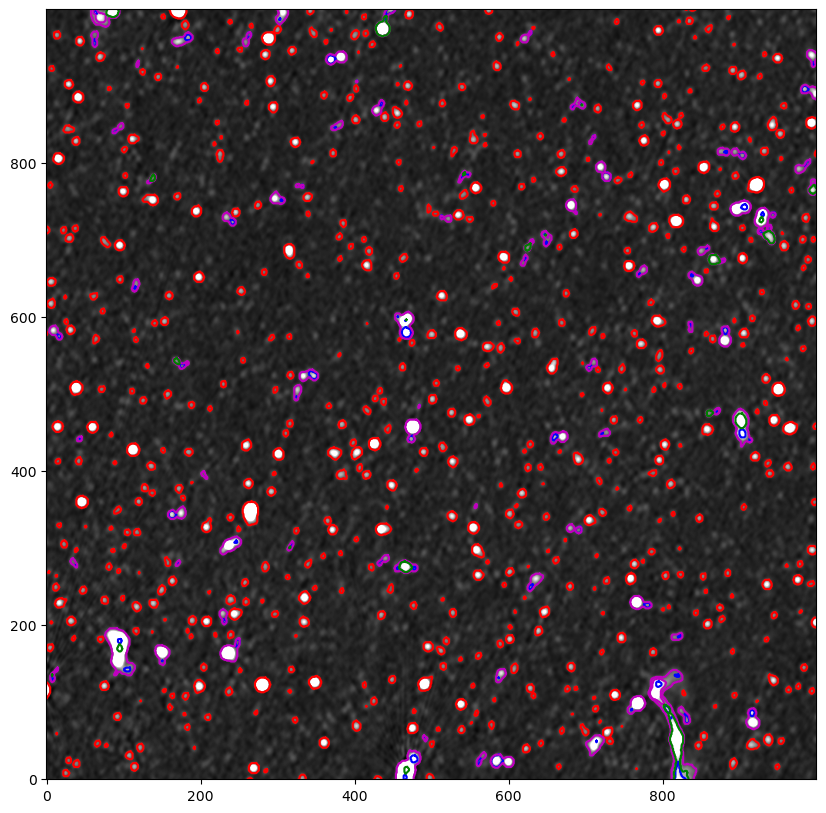

In [14]:

plt.figure(figsize=(10,10))
plt.imshow(img,cmap='gray',origin='lower',vmax=0.0001)

for i in range(len(cat0)):
    row = cat0.iloc[i]
   # print(row)
    birth = row['Birth']
    death = row['Death']
    mask = np.zeros(img.shape)
    mask = np.logical_or(mask,np.logical_and(img<=birth, img>death))
    #print(birth,death)
    #print(img[int(row.x1),int(row.y1)])
    #plt.scatter(row.y1,row.x1,color='r',marker='+')
    #plt.imshow(img,cmap='gray',origin='lower',vmax=0.001)
    #plt.show()
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='r')
    
for i in range(len(cat1)):
    row = cat1.iloc[i]
    birth = row['Birth']
    death = row['Death']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='b')

for i in range(len(cat2)):
    #try:
    row = cat2.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='m')
    
for i in range(len(cat3)):
    row = cat3.iloc[i]
    death = row['Death']
    birth = row['Birth']
    mask = np.logical_and(img<=birth, img>death)
    mask = get_enclosing_mask(int(row.y1),int(row.x1),mask)
    contour = measure.find_contours(mask)[0]
    plt.plot(contour[:,1],contour[:,0],color='g')